In [1]:
# Quadrotic programming을 위한 패키지 설치
#!pip install cvxopt

# Random Portfolio Generation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

# Random weight generation
def rand_weights(n):
    weights = np.random.random(n)
    weights /= np.sum(weights)
    return weights

# Random portfolio generation
def random_portfolio(returns):
    # multiplying 252 for annualizing
    p = np.asmatrix(np.mean(returns)*252)
    w = np.asmatrix(rand_weights(returns.shape[1]))
    C = np.asmatrix(returns.cov()*252)
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

# Monte-Carlo simulation of random portfolios
def MC_portfolio(returns, n_portfolios=1000):
    means, stds = np.column_stack([random_portfolio(returns)
                                  for _ in range(n_portfolios)])
    return means, stds


0.626 0.14


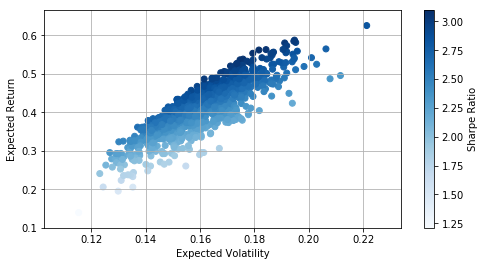

In [2]:
price = pd.read_excel('k10_historical_price.xlsx')
rets = price/price.shift(1)-1
rets.dropna(inplace=True)
mean, std = MC_portfolio(rets)
print(mean.max().round(3), mean.min().round(3))

plt.figure(figsize=(8,4))
plt.scatter(std, mean, c=mean/std, marker='o', cmap=mpl.cm.Blues)
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label = 'Sharpe Ratio')

# Efficient Frontier Calculation by Quadrotic Programming

In [3]:
# 계산 과정 표시 하지 않음
solvers.options['show_progress'] = False

weight_list = []
return_range = np.linspace(mean.min().round(3)*0.5, mean.max().round(3)*2, 50)

"""
Minimizing quadrotic equiation
1/2 * x.T * P * x + q.T * x

with constraint s.t.
Gx <= h ; 각 weight가 양수인 조건
Ax = B ; weight들의 합은 1인 조건 & rets을 weight로 가중평균한게 portfolio return 되는 조건

Here, 
x = weight vector (n by 1)
P = Covariance matric (n by n)
q = zero vector (n by 1)
G = -I (n by n)
A = 첫 행은 1, 둘째 행은 E(ret) (2 by n)
B = [[1, portfolio return]] (2 by 1)

"""

# Annualized 시킨것을 놓치면 optimize 실패 하니 주의.
# Find minimum variance portfolio given portfolio return m & iterate m
for m in return_range:
    P = opt.matrix(np.asmatrix(rets.cov()*252))
    q = opt.matrix(np.asmatrix(np.zeros(10)).T)
    G = opt.matrix(np.asmatrix(-np.eye(10)))
    h = opt.matrix([0.0]*10)
    A = opt.matrix(np.asmatrix(np.vstack((np.ones(10),np.array(rets.mean()*252)))))
    B = opt.matrix(np.asmatrix(np.array([[1],[m]])))

    w = np.array(solvers.qp(P,q,G,h,A,B)['x']).round(3)
    weight_list.append(w)

EF_rets = np.array([np.dot(weight_list[i].T,np.array(rets.mean()*252))[0] for i in range(25)])
EF_stds = np.array([np.sqrt(np.dot(weight_list[i].T,np.dot(rets.cov()*252,weight_list[i])))[0][0] for i in range(25)])
EF_sharpe = EF_rets/EF_stds

In [4]:
maxSR_index = np.where(EF_sharpe == EF_sharpe.max())[0][0]
MF_ret, MF_std = EF_rets[maxSR_index], EF_stds[maxSR_index]
MF_weight = weight_list[maxSR_index]

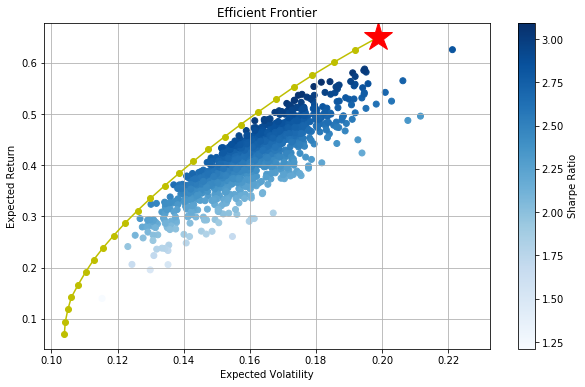

In [5]:
plt.figure(figsize=(10,6))
plt.scatter(std, mean, c=mean/std, marker='o', cmap=mpl.cm.Blues) # Random portfolio
plt.plot(EF_stds, EF_rets, 'y-o') # Effcient frontier
plt.plot(MF_std, MF_ret, 'r*', markersize=30) # Market tangency portfolio
plt.grid(True)
plt.title('Efficient Frontier')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label = 'Sharpe Ratio')

# Calculation of Capital Market Line (CML)

In [6]:
import scipy.optimize as sco
import scipy.interpolate as sci

tck = sci.splrep(EF_stds, EF_rets)

def f(x):
    
    '''보간법으로 정의된 Efficient frontier 함수'''
    return sci.splev(x, tck, der=0)

def df(x):
    
    '''Efficient frontier의 1차 미분'''
    return sci.splev(x, tck, der=1)

def CML(p, rf = 0.02):
    '''자본시장선을 정의하는 함수 p(a,b,x)
        a = rf
        a + bx = f(x)
        b = df(x) '''
    
    eq1 = rf - p[0]
    eq2 = rf + p[1]*p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    
    return eq1, eq2, eq3    

In [7]:
opt = sco.fsolve(CML, [0.01, 0.5, 0.15])

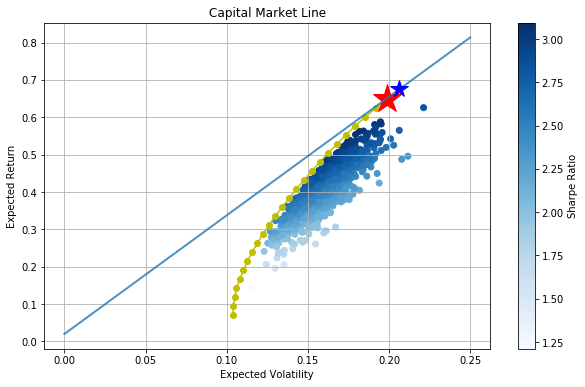

In [8]:
plt.figure(figsize=(10,6))
plt.scatter(std, mean, c=mean/std, marker='o', cmap=mpl.cm.Blues) # Random portfolio
plt.plot(EF_stds, EF_rets, 'y-o') # Effcient frontier
plt.plot(MF_std, MF_ret, 'r*', markersize=30) # Market tangency portfolio

cx = np.linspace(0.0, 0.25)
plt.plot(cx, opt[0]+opt[1]*cx, lw=2, alpha=0.8)
plt.plot(opt[2], f(opt[2]), 'b*', markersize=18.0) 

plt.plot()
plt.grid(True)
plt.title('Capital Market Line')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label = 'Sharpe Ratio')